In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Модель LGBM

In [121]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgb

import shap

import os
import src

from dotenv import load_dotenv

import joblib

In [123]:
pd.options.display.float_format = '{:,.2f}'.format

## Подготовка данных

In [124]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
FILE_NAME = 'df_work_test.zip'

filepath = f'..\\{WORK_DIR}\\{FILE_NAME}'

df1 = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [125]:
df1.shape

(47552, 50)

In [126]:
df1.columns

Index(['QQ_C1', 'QQ_C2', 'QQ_C3', 'QQ_C4', 'QQ_C5', 'O2_tot', 'QQ_tot',
       'O2_C1', 'O2_C2', 'O2_C3', 'O2_C4', 'O2_C5', 'AC_level', 'P_H2O',
       'P_O2', 'P_tot', 'P_valve', 'T_abg', 'Fe', 'Stot', 'As', 'Corg', 'Ctot',
       'Fe2+', 'D_S', 'D_SL_H', 'ac', 'Fel_sum', 'C_Solid', 'Q_SL', 'G_Solid',
       'G_Seq', 'G_FeS2', 'G_FeAsS', 'G_O2_st', 'O2_part', 'BettaS_O2_1',
       'BettaS_O2_2', 'BettaS_O2_3', 'BettaS_O2_4', 'BettaS_O2_5', 'QQ_tot_sl',
       'BettaS_QW_1', 'BettaS_QW_2', 'BettaS_QW_3', 'BettaS_QW_4',
       'BettaS_QW_5', 'lag_1', 'lag_2', 'lag_3'],
      dtype='object')

In [127]:
X = df1.drop(['Fe2+', 'ac'], axis=1)
X = X.reset_index(drop=True)
y = df1['Fe2+']
y = y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [128]:
X_train.shape

(38041, 48)

## Тренировка модели

In [129]:
# model = lgb.LGBMRegressor(metric='rmse', n_estimators=1000, linear_tree=True)
param = {
    'max_bin': 100,
    'num_leaves': 200,
    'max_depth': 20,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'n_estimators': 1000,
    'learning_rate': 0.1
}

# model = lgb.LGBMRegressor(metric='rmse', n_estimators=1000, learning_rate=0.05)
model = lgb.LGBMRegressor(
    metric='rmse',
    max_bin = 100,
    num_leaves = 200,
    n_estimators = 1000,
    learning_rate = 0.2
)

In [130]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='l2', early_stopping_rounds=100)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='mae')

[1]	valid_0's l2: 0.600039	valid_0's rmse: 0.774622
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.531577	valid_0's rmse: 0.729093
[3]	valid_0's l2: 0.485768	valid_0's rmse: 0.696971
[4]	valid_0's l2: 0.453463	valid_0's rmse: 0.673396
[5]	valid_0's l2: 0.429065	valid_0's rmse: 0.655031
[6]	valid_0's l2: 0.414121	valid_0's rmse: 0.643523
[7]	valid_0's l2: 0.403514	valid_0's rmse: 0.635228
[8]	valid_0's l2: 0.394863	valid_0's rmse: 0.628381
[9]	valid_0's l2: 0.386131	valid_0's rmse: 0.621394
[10]	valid_0's l2: 0.376518	valid_0's rmse: 0.613611
[11]	valid_0's l2: 0.374671	valid_0's rmse: 0.612103
[12]	valid_0's l2: 0.367811	valid_0's rmse: 0.606474
[13]	valid_0's l2: 0.361507	valid_0's rmse: 0.601254
[14]	valid_0's l2: 0.355328	valid_0's rmse: 0.596094
[15]	valid_0's l2: 0.351805	valid_0's rmse: 0.593131
[16]	valid_0's l2: 0.346902	valid_0's rmse: 0.588984
[17]	valid_0's l2: 0.342525	valid_0's rmse: 0.585256
[18]	valid_0's l2: 0.339564	valid_0's rmse: 0.

LGBMRegressor(learning_rate=0.2, max_bin=100, metric='rmse', n_estimators=1000,
              num_leaves=200)

Метрики качества
RMSE: 0.4903
MAE: 0.1447
R2: 0.6585


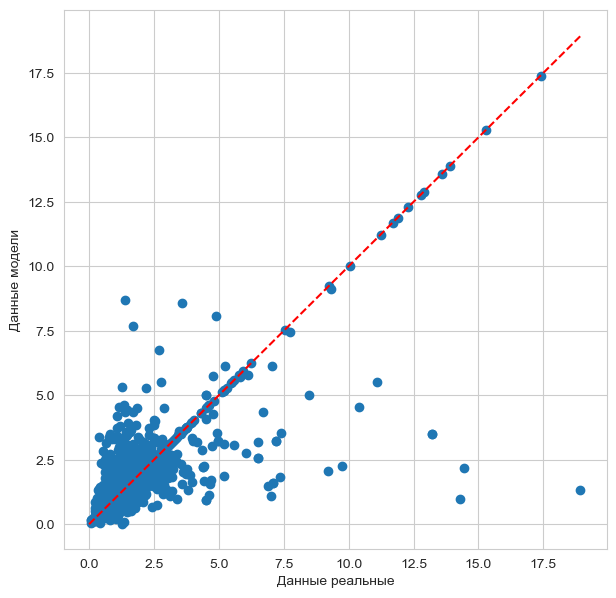

In [131]:
src.lib.model_score(model, X_test, y_test)

"Наивный прогноз". Посчитаем метрики качества, если модель будет всегда выдать среднее значение концентрации железа.

In [148]:
y_mean = y_train.mean()
naive_pred = np.full(y_test.shape, fill_value=y_mean)
mean_absolute_error(y_test, naive_pred)

0.4733168386783174

In [149]:
mean_squared_error(y_test, naive_pred) ** 0.5

0.8390199522765521

In [132]:
pred = model.predict(X_test)

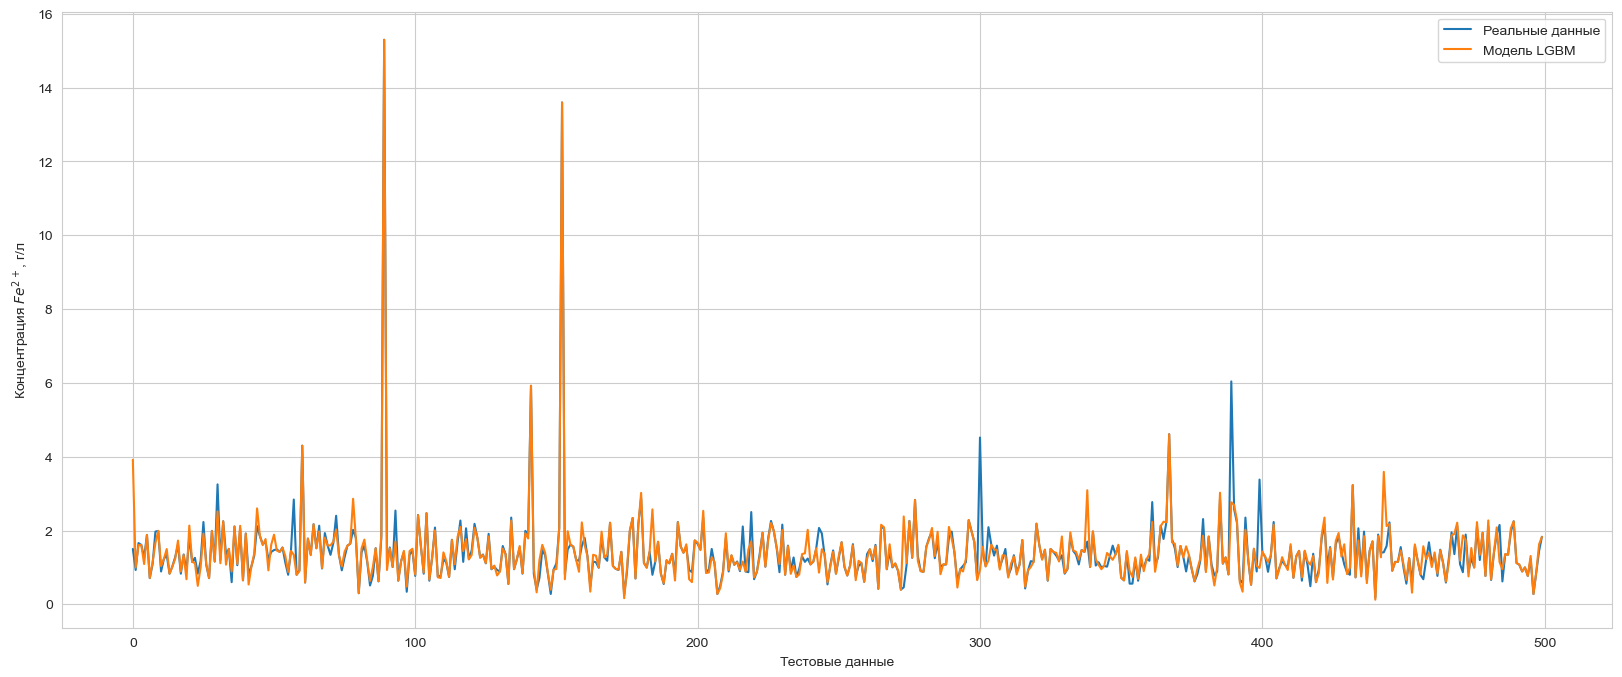

In [133]:
plt.figure(figsize=(20,8))

start = 2500
end = 3000

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred[start:end], label='Модель LGBM')

plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

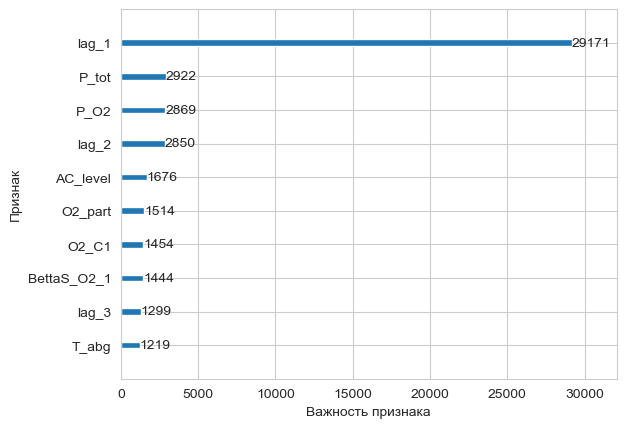

In [161]:
ax = lgb.plot_importance(model, importance_type='gain', max_num_features=10, title="", grid=True, precision=0)
ax.set_ylabel("Признак")
ax.set_xlabel("Важность признака")

plt.show();

## Посмотрим наиболее важные признаки

In [134]:
# model.params["objective"] = "regression"
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

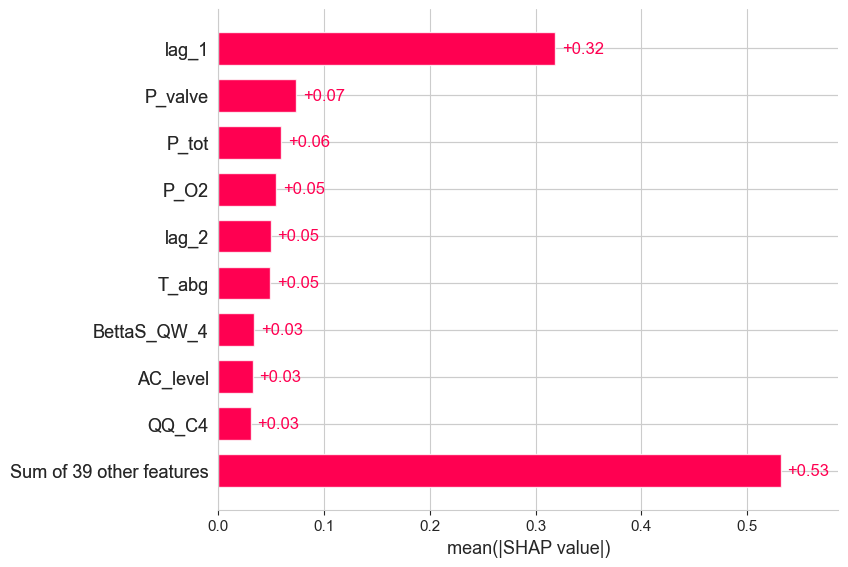

In [135]:
shap.plots.bar(shap_values)

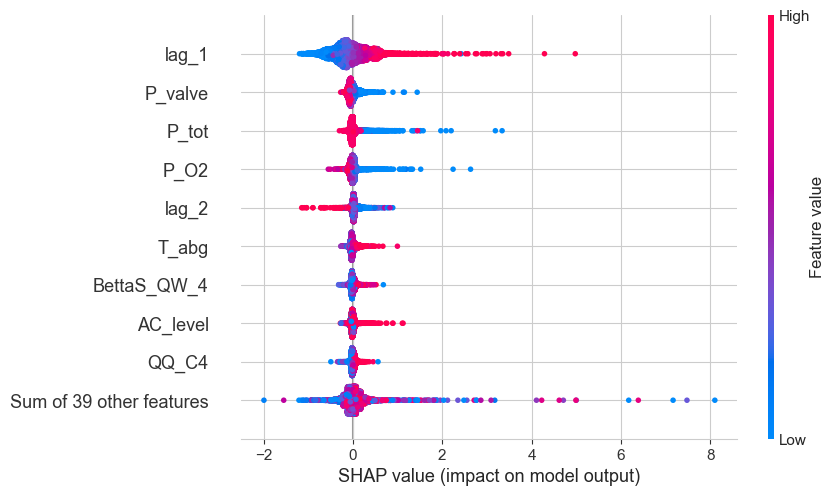

In [136]:
shap.plots.beeswarm(shap_values)

In [137]:
diff = y_test - pred

diff_df = pd.DataFrame(diff)
diff_df = diff_df.assign(real=y_test)
diff_df = diff_df.assign(pred=pred)
diff_df.reset_index(inplace=True)

diff_df.columns = ['Data', 'Diff', 'Real', 'Pred']

diff_df.head()

,Data,Diff,Real,Pred
0,16463,-0.00,0.37,0.37
1,44306,-0.30,0.91,1.21
2,1232,-0.09,0.12,0.21
3,31023,-0.00,0.76,0.76
4,1900,-0.03,1.02,1.05


In [138]:
diff_df.loc[diff_df['Diff'] > 1].sort_values(by=['Diff'], ascending=False)[:10]

,Data,Diff,Real,Pred
3846,42163,17.58,18.90,1.32
2391,42704,13.33,14.30,0.97
3511,36532,12.26,14.43,2.17
800,16953,9.69,13.20,3.51
4204,28631,9.69,13.20,3.51
3240,43628,7.49,9.76,2.27
5021,5488,7.13,9.20,2.07
7814,4520,5.92,7.00,1.08
1159,6948,5.87,10.40,4.53
1226,40090,5.57,11.10,5.53


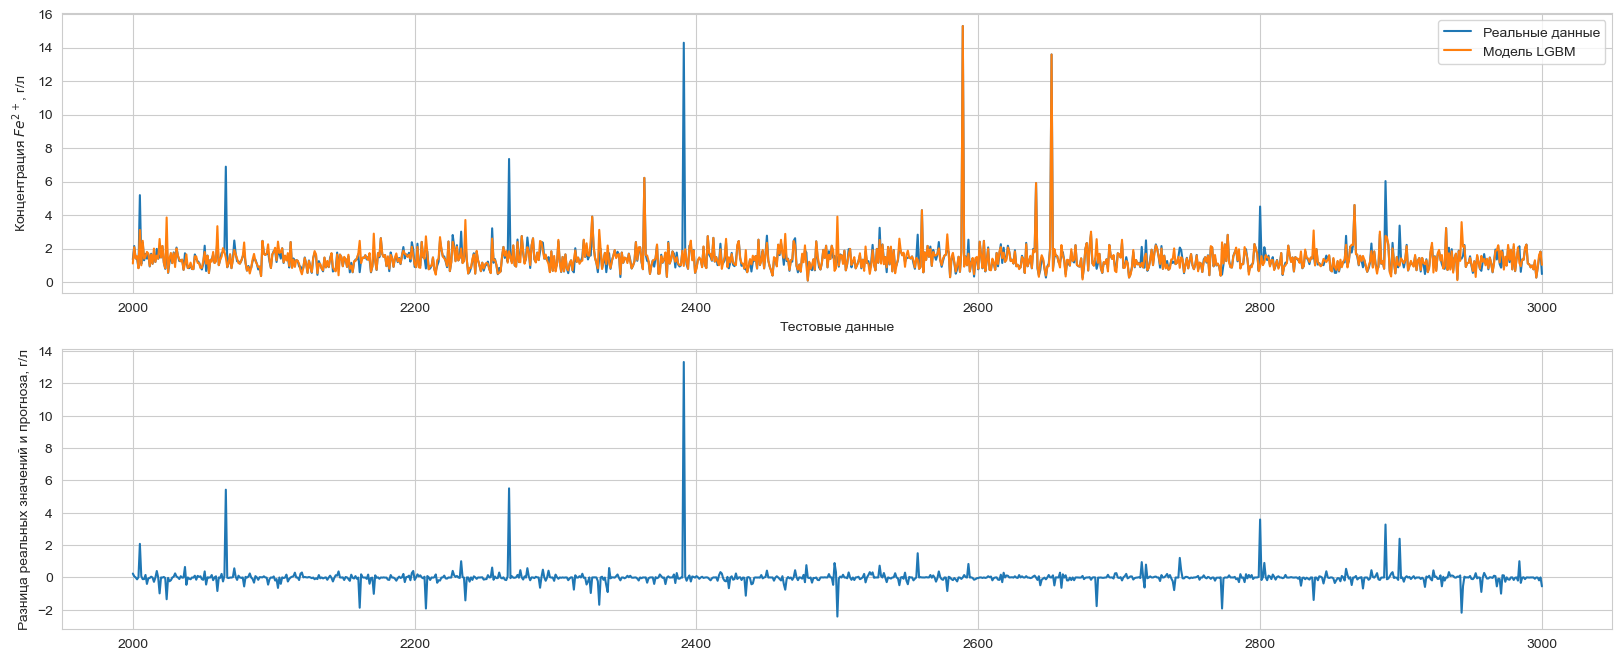

In [139]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))

start = 2000
end = 3000

axs[0].plot(diff_df.loc[start:end, 'Real'], label='Реальные данные')
axs[0].plot(diff_df.loc[start:end, 'Pred'], label='Модель LGBM')

axs[1].plot(diff_df.loc[start:end, 'Diff'], label='Модель LGBM')

axs[0].set_ylabel("Концентрация $Fe^{2+}$, г/л")
axs[0].set_xlabel('Тестовые данные')
axs[0].legend()

axs[1].set_ylabel("Разница реальных значений и прогноза, г/л")

plt.show();

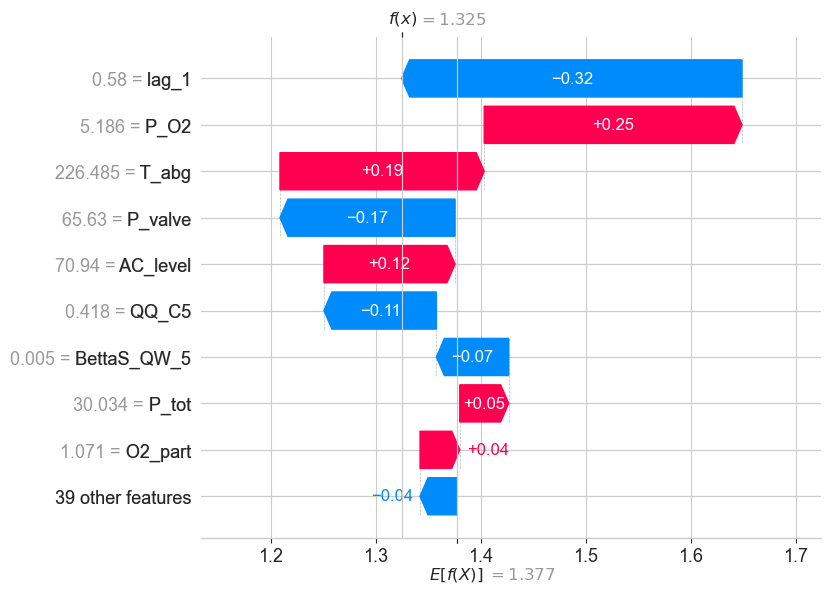

In [140]:
shap.plots.waterfall(shap_values[3846])

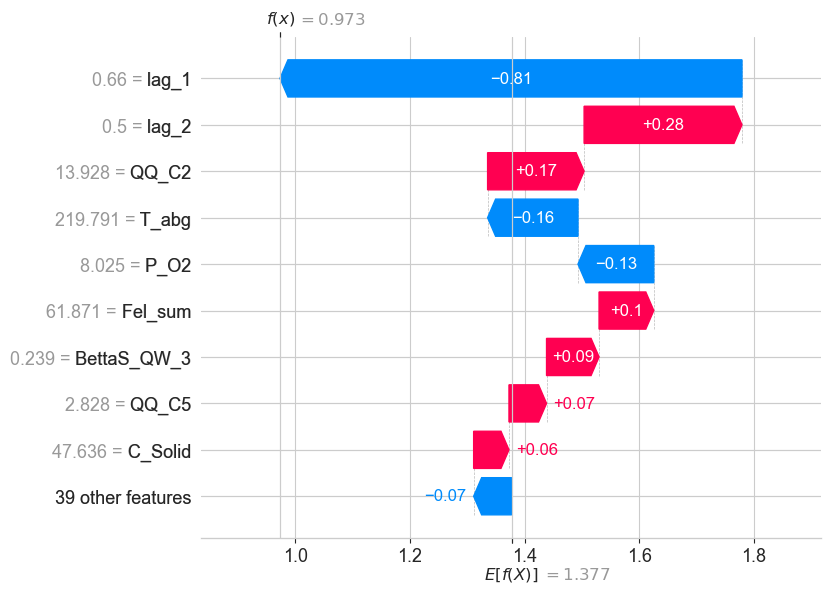

In [141]:
shap.plots.waterfall(shap_values[2391])

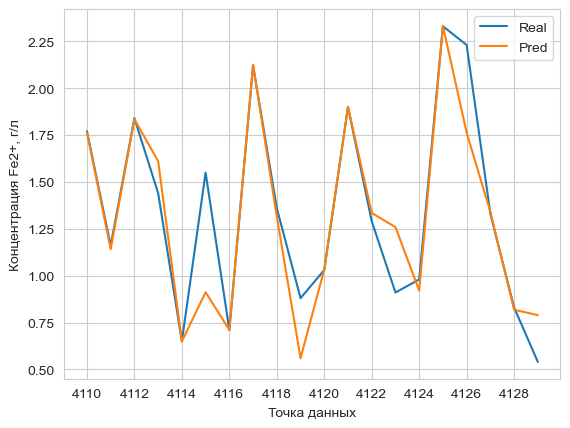

In [142]:
diff_df[['Real', 'Pred']].iloc[4110:4130].plot(xlabel = "Точка данных", ylabel="Концентрация Fe2+, г/л", xticks=np.arange(4110, 4130, 2));

## Сохранение модели

In [143]:
joblib.dump(model, '../models/model_lgb_opt.pkl')

['../models/model_lgb_opt.pkl']

Потом загрузка модели - gbm_pickle = joblib.load('lgb.pkl')